In [1]:
import os
import shutil
import numpy as np
import pickle
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import random_split

from Task_1.synthetic_dataset import SyntheticDataset
from Task_1.trainer import Trainer
from Task_1.deeponet import *
from Task_1.utils import collate_fn_fixed, collate_fn

from torch.utils.tensorboard import SummaryWriter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 256

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_dataset = SyntheticDataset(10000, 128, padding=False, verbose=True)
valid_dataset = SyntheticDataset(1000, 128, padding=False, verbose=True, test=True)

Sampling Functions from Beta Distribution 1/6 with a=1, b=2: 100%|██████████| 1666/1666 [00:07<00:00, 208.68it/s]
Sampling Functions from Beta Distribution 2/6 with a=1, b=5: 100%|██████████| 1666/1666 [00:07<00:00, 229.68it/s]
Sampling Functions from Beta Distribution 3/6 with a=2, b=1: 100%|██████████| 1666/1666 [00:06<00:00, 244.11it/s]
Sampling Functions from Beta Distribution 4/6 with a=2, b=5: 100%|██████████| 1666/1666 [00:06<00:00, 246.06it/s]
Sampling Functions from Beta Distribution 5/6 with a=5, b=1: 100%|██████████| 1666/1666 [00:07<00:00, 221.62it/s]
Sampling Functions from Beta Distribution 6/6 with a=5, b=2: 100%|██████████| 1670/1670 [00:06<00:00, 249.30it/s]
Generating Observations: 100%|██████████| 10000/10000 [00:00<00:00, 13345.79it/s]
Sampling Functions from Beta Distribution 1/6 with a=1, b=2: 100%|██████████| 166/166 [00:00<00:00, 181.14it/s]
Sampling Functions from Beta Distribution 2/6 with a=1, b=5: 100%|██████████| 166/166 [00:00<00:00, 168.81it/s]
Sampling F

## Visualize dataset

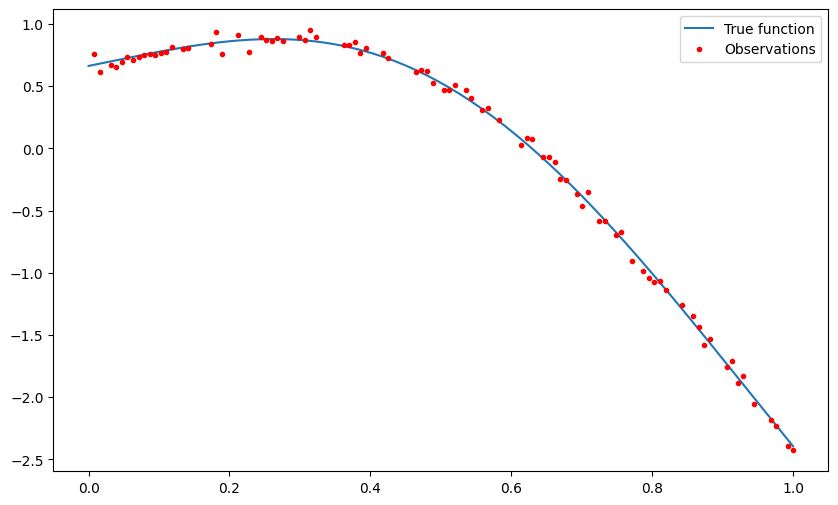

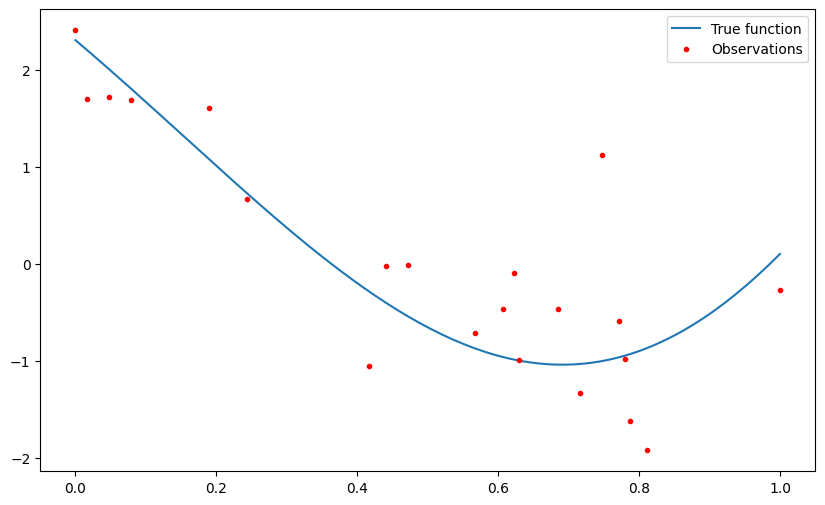

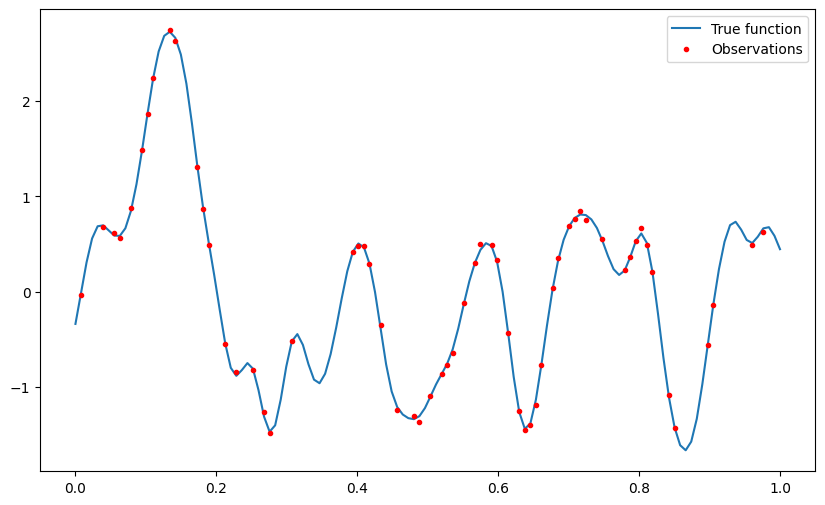

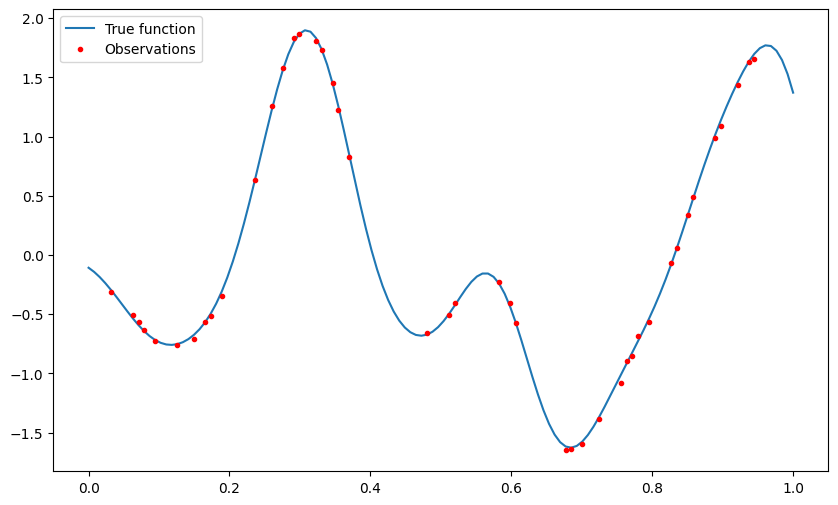

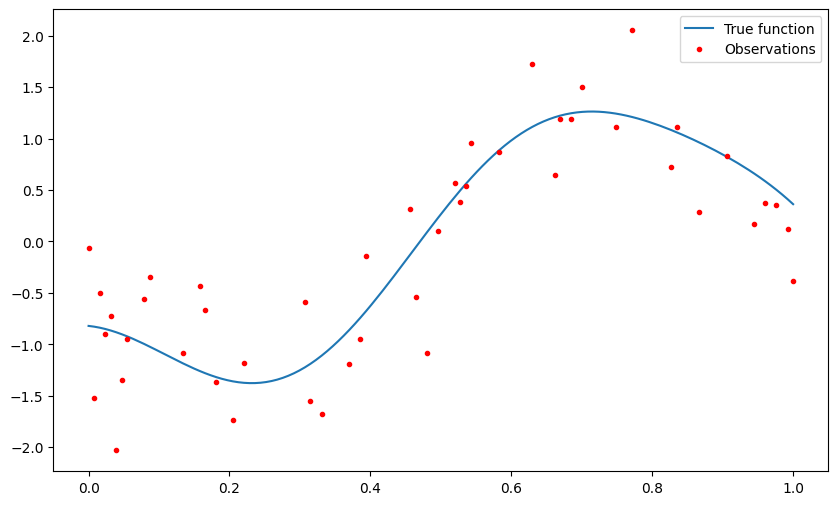

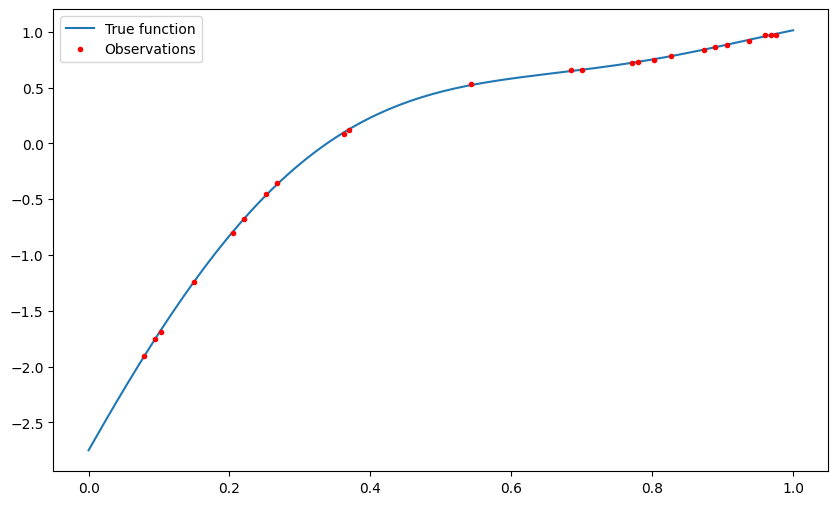

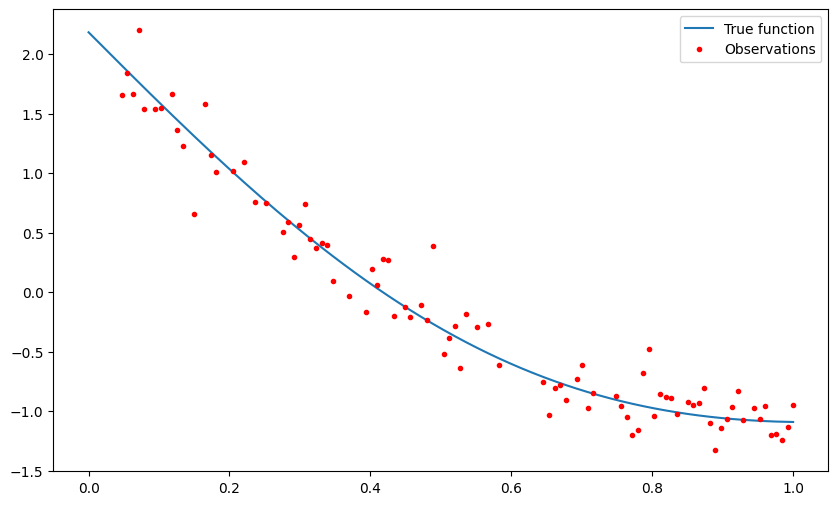

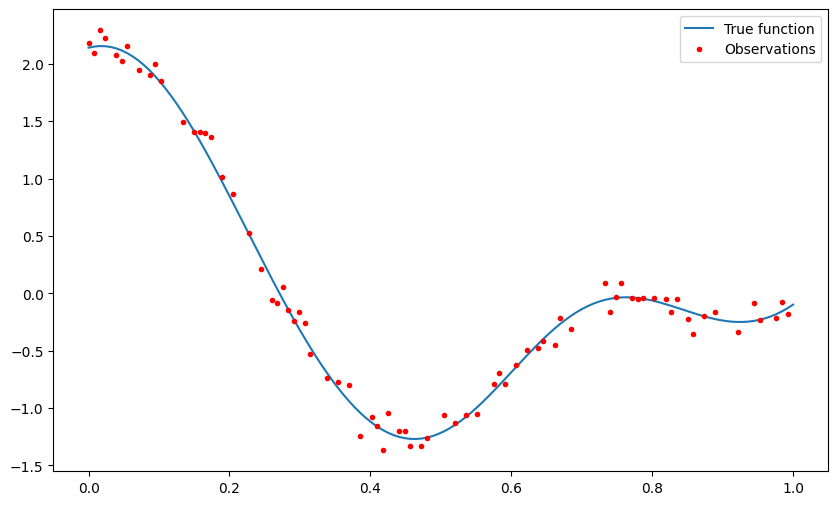

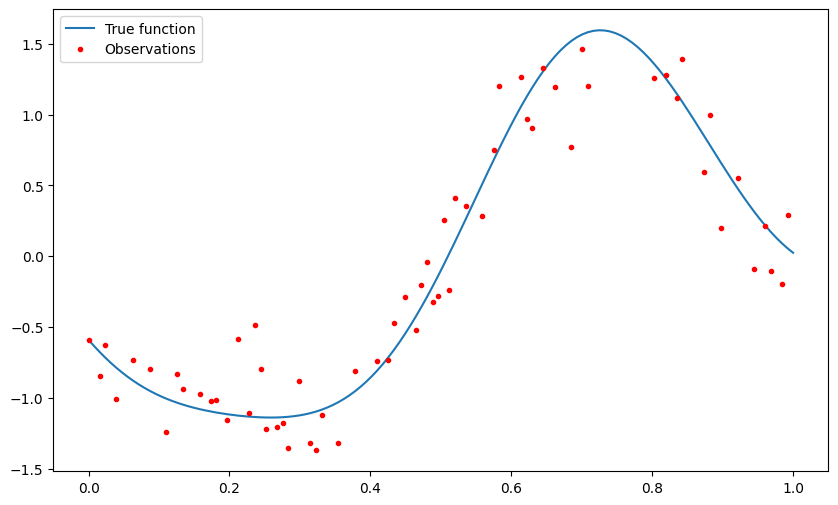

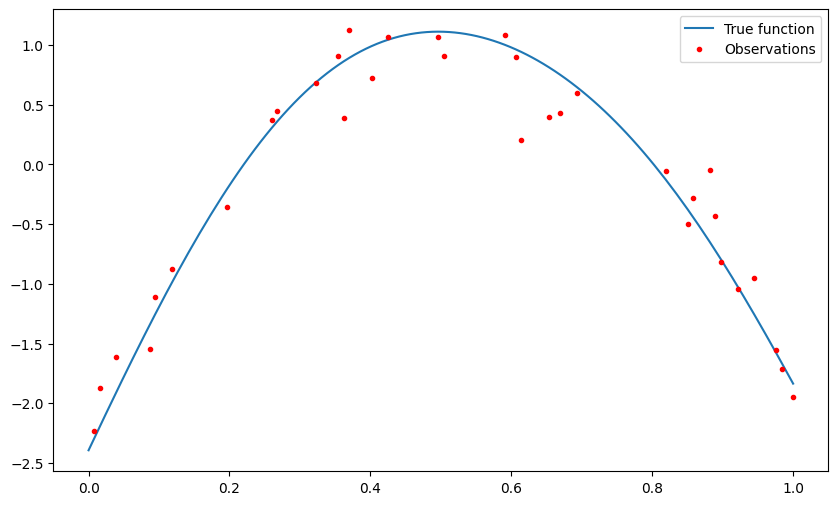

In [4]:
X = np.linspace(0, 1, 128)
i = 0
for function_values, observations, masks in train_dataset:
    observation_values, observation_time_points = observations

    plt.figure(figsize=(10,6))
    plt.plot(X, function_values, label='True function')
    plt.plot(observation_time_points, observation_values, marker='.', color='red', linestyle='None', label='Observations')
    plt.legend()
    plt.show()
    i += 1
    if i == 10:
        break

### Using dynamic padding to pad to the maximum sequence length in a batch

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
validation_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [6]:
for (true_values, observations, masks) in train_loader:
    values, times = observations
    print(true_values.shape, values.shape, masks.shape)
    print(masks[0])
    print(values[0])
    print(times[0])
    break

torch.Size([256, 128]) torch.Size([256, 100]) torch.Size([256, 100])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([ 2.0188,  1.9356,  1.8599,  1.8248,  1.7168,  1.7551,  1.5215,  1.4597,
         1.3406,  1.4811,  1.3600,  1.2989,  1.2627,  1.0102,  1.2515,  0.8980,
         1.0085,  1.0250,  0.6715,  0.9380,  0.6406,  0.8136,  0.5013,  0.4899,
         0.3981,  0.4455,  0.5037,  0.3143,  0.3354,  0.1588,  0.2707,  0.2385,
         0.0941, -0.0387, -0.0388,  0.0398, -0.1941, -0.2540, -0.2449, -0.3229,
        -0.4177, -0.3544, -0.3018, -0.5279, -0.4907, -0.5093, -0.7109, -0.6934,
  

### Using fixed padding to get sequence length of 128

In [7]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_fixed)
validation_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_fixed)

In [8]:
for (true_values, observations, masks) in train_loader:
    values, times = observations
    print(true_values.shape, values.shape, masks.shape)
    print(masks[0])
    print(values[0])
    print(times[0])
    break

torch.Size([256, 128]) torch.Size([256, 128]) torch.Size([256, 128])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
tensor([ 0.3516, -0.1129,  0.1540,  0.1371,  0.5053,  0.6745,  1.0872,  0.6944,
         0.4034, -0.0213, -0.7348, -1.2059, -1.5861, -2.3354, -2.0998, -1.5807,
        -0.8737, -0.7217, -0.5557, -0.4499, -0.5469, -0.9065, -0.3765, -0.2846,
        -0.3765,  0.0703,  0.0562,  0.4881,  0.9037,  1.4666,  1.2180,  1.6780,
         1.6541,  1.4660,  1.0247,

## Model Trainig

In [10]:
TBOARD_LOGS = os.path.join("./Task_1", "tboard_logs", "model_task1")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)
shutil.rmtree(TBOARD_LOGS) 
writer = SummaryWriter(TBOARD_LOGS)

indicator_dim = 128

deeponet = DeepONet(indicator_dim=indicator_dim, d_model=128, heads=2, p=128).to(device)
criterion = nn.MSELoss()
trainer = Trainer(model=deeponet, criterion=criterion, train_loader=train_loader, valid_loader=validation_loader, modelname="model_task1", epochs=1, writer=writer)

In [11]:
trainer.fit()

Ep 0 Iter 1: Loss=8.0386:   0%|          | 0/40 [00:01<?, ?it/s]

Valid loss @ iteration 0: Loss=3.222940504550934


Ep 0 Iter 40: Loss=0.76329:  98%|█████████▊| 39/40 [00:31<00:00,  1.22it/s]


<Figure size 640x480 with 0 Axes>